<a href="https://colab.research.google.com/github/CaQtiml/Kaggle_Practice/blob/main/Neural_Style_Transfer_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
import pprint
%matplotlib inline

In [ ]:
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='imagenet')

vgg.trainable = False
pp.pprint(vgg)

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
img_size = 400

(1, 400, 400, 3)


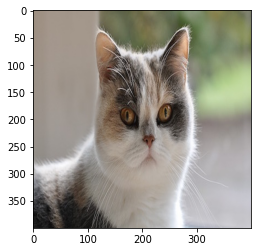

In [ ]:
content_image = np.array(Image.open("cat.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

(1, 400, 400, 3)


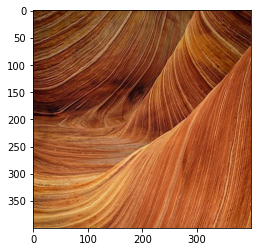

In [ ]:
style_image =  np.array(Image.open("sandstone.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

(1, 400, 400, 3)


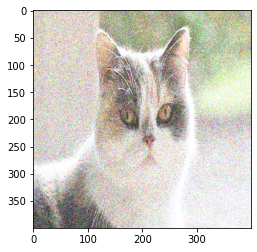

In [ ]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), 0, 0.5)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

In [ ]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 400, 400, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 200, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 100, 128)     0     

In [ ]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [ ]:
STYLE_LAYERS = [
    ('block1_conv1', 0.52),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.02)]

In [ ]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [ ]:
content_target = vgg_model_outputs(content_image)  # Content encoder
content_target[1]
# style_targets = vgg_model_outputs(style_image)     # Style enconder

### Compute the content cost

`tf.reshape(a_C, shape=[m, n_H * n_W, n_C])` gives the same result as `tf.reshape(a_C, shape=[m, -1, n_C])`.

In [ ]:
def compute_content_cost(content_output, generated_output):
    a_C = content_output[-1]
    a_G = generated_output[-1]

    m, n_H, n_W, n_C = a_G.get_shape().as_list()

    J_content = (1/(4*n_H*n_W*n_C)) * tf.reduce_sum(tf.subtract(a_C,a_G)**2)
    return J_content

In [ ]:
# preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
# a_C = vgg_model_outputs(preprocessed_content)
# a_G = vgg_model_outputs(generated_image)

### Compute the style cost

In [ ]:
def gram_matrix(A): 
    
    GA = A@tf.transpose(A)
    return GA

In [ ]:
def compute_layer_style_cost(a_S, a_G):
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S,shape=[-1,n_C]))
    a_G = tf.transpose(tf.reshape(a_G,shape=[-1,n_C]))

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    style_cost = (1/(4*n_C**2*(n_H*n_W)**2))*tf.reduce_sum(tf.subtract(GS,GG)**2)

    return style_cost

In [ ]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
   
    J_style = 0

    a_S = style_image_output[:-1]
    a_G = generated_image_output[:-1]

    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])
        J_style += weight[1] * J_style_layer

    return J_style

### Some Utils

In [ ]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

### Train Step

In [ ]:
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [ ]:
# @tf.function
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    J = alpha*J_content + beta*J_style
    return J

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# @tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        a_G = vgg_model_outputs(generated_image)
        J_style = compute_style_cost(a_S, a_G)
        J_content = compute_content_cost(a_C, a_G)
        J = total_cost(J_content,J_style) 

    grad = tape.gradient(J, generated_image)
    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))

    return J

### Train the model

Epoch 0 


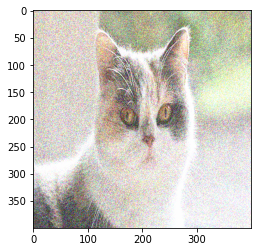

Epoch 1000 


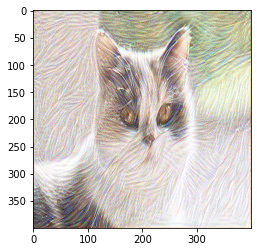

Epoch 2000 


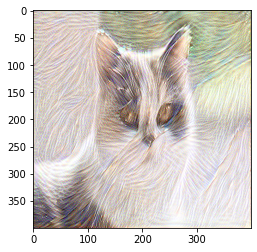

Epoch 3000 


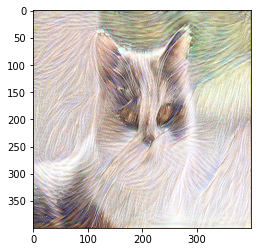

Epoch 4000 


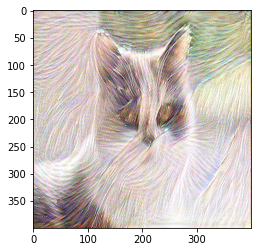

Epoch 5000 


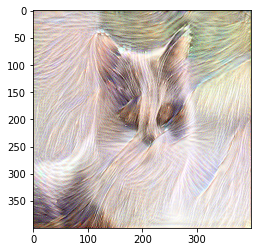

Epoch 6000 


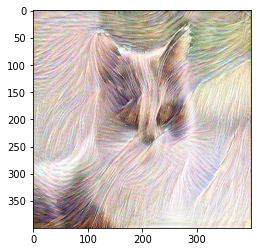

Epoch 7000 


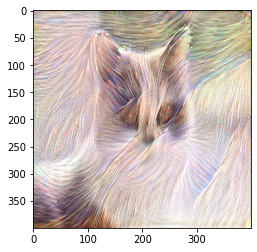

In [ ]:
generated_image = tf.Variable(tf.image.convert_image_dtype(generated_image, tf.float32))
epochs = 7500
for i in range(epochs):
    train_step(generated_image)
    if i % 1000 == 0:
        print(f"Epoch {i} ")
    if i % 1000 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        # image.save(f"output/image_{i}.jpg")
        plt.show() 